# Bayesian Fama-French Factor Model

### Data Settings

In [186]:
import pandas as pd
import numpy as np
import pickle
import warnings
import random
warnings.filterwarnings("ignore")
SEED = 42
np.random.seed(SEED)
random.seed(SEED)


data_path = 'simulation_data'

start_date = '2016-03-30'
end_date = '2025-03-20'
with open(f"{data_path}/KS200_MASK.pkl", 'rb') as f:
    mask_df:pd.DataFrame = pickle.load(f).ffill(axis=1)
    mask_df = mask_df.loc[:, start_date:end_date]
with open(f"{data_path}/Return.pkl", 'rb') as f:
    returns_df = pickle.load(f).ffill(axis=1) * 0.01
    returns_df = returns_df.loc[:, start_date:end_date]
with open(f"{data_path}/MarketCap.pkl", 'rb') as f:
    mc_df = pickle.load(f).ffill(axis=1)
    mc_df = mc_df.loc[:, start_date:end_date]
with open(f"{data_path}/ifrs-full_Equity.pkl", 'rb') as f:
    be_df = pickle.load(f).ffill(axis=1)
    be_df = be_df.loc[:, start_date:end_date]
with open(f"{data_path}/KOSPI_Close.pkl", 'rb') as f:
    kospi_close_df = pickle.load(f).ffill(axis=1)
    kospi_return_df = kospi_close_df.pct_change(axis=1)
    mkt_df = kospi_return_df.loc[:, start_date:end_date]
with open(f"{data_path}/rf_bond.pkl", 'rb') as f:
    rf_df = pickle.load(f).ffill(axis=1) * 0.01
    rf_df = rf_df.loc[:, start_date:end_date]
with open(f"{data_path}/corp_aa_bond.pkl", 'rb') as f:
    corp_aa_df = pickle.load(f).ffill(axis=1) * 0.01
    corp_aa_df = corp_aa_df.loc[:, start_date:end_date]
with open(f"{data_path}/corp_bb_bond.pkl", 'rb') as f:
    corp_bb_df = pickle.load(f).ffill(axis=1) * 0.01
    corp_bb_df = corp_bb_df.loc[:, start_date:end_date]
with open(f"{data_path}/gov10_bond.pkl", 'rb') as f:
    gov10_df = pickle.load(f).ffill(axis=1) * 0.01
    gov10_df = gov10_df.loc[:, start_date:end_date]
with open(f"{data_path}/gov3_bond.pkl", 'rb') as f:
    gov3_df = pickle.load(f).ffill(axis=1) * 0.01
    gov3_df = gov3_df.loc[:, start_date:end_date]
corp_df = (corp_aa_df + corp_bb_df) / 2

In [187]:
R     = returns_df
MC    = mc_df
BE    = be_df 
RF = rf_df / 252 # 일단위 reblancing 시행하므로 252로 나누어 줌.
GOV10   = gov10_df / 252
GOV3 = gov3_df / 252
CORP  = corp_df / 252
MKT   = mkt_df
mask  = mask_df.astype(bool)

dates = R.columns
tickers = R.index

In [188]:
port_rets = {f"S{i}B{j}":[] for i in range(1,6) for j in range(1,6)}

for dt in dates:
    members = mask[dt][mask[dt]].index
    if members.empty: 
        continue

    # size quintile breakpoints
    me = MC.loc[members, dt].dropna()
    sz_br = me.quantile([0.2,0.4,0.6,0.8]).values

    # BE/ME quintile breakpoints
    bm = (BE.loc[members, dt] / MC.loc[members, dt]).dropna()
    bm_br = bm.quantile([0.2,0.4,0.6,0.8]).values

    # 각 포트폴리오
    for i in range(1,6):
        size_idx = me[
            (me >  (sz_br[i-2] if i>1 else -np.inf)) &
            (me <= (sz_br[i-1] if i<5 else  np.inf))
        ].index
        for j in range(1,6):
            bm_idx = bm[
              (bm >  (bm_br[j-2] if j>1 else -np.inf)) &
              (bm <= (bm_br[j-1] if j<5 else  np.inf))
            ].index

            idx = size_idx.intersection(bm_idx)
            name = f"S{i}B{j}"
            if idx.empty:
                ret = np.nan
            else:
                w = MC.loc[idx, dt]
                w = w / w.sum()
                ret = (R.loc[idx, dt] * w).sum()
            port_rets[name].append((dt, ret))

# DataFrame으로 변환
port_df = pd.DataFrame({
    name: pd.Series(dict(port_rets[name]))
    for name in port_rets
}).sort_index(axis=1)
port_df = port_df.interpolate(method='linear', axis=0, limit_direction='both')


# ── 2) SMB, HML 계산 ──
# SMB: size quintile 1 평균 – quintile 5 평균
SMB = (port_df[[f"S1B{j}" for j in range(1,6)]].mean(axis=1) + port_df[[f"S2B{j}" for j in range(1,6)]].mean(axis=1)) \
        - (port_df[[f"S5B{j}" for j in range(1,6)]].mean(axis=1) + port_df[[f"S4B{j}" for j in range(1,6)]].mean(axis=1)) 

# HML: BE quintile 5 평균 – quintile 1 평균
HML = (port_df[[f"S{i}B5" for i in range(1,6)]].mean(axis=1) + port_df[[f"S{i}B4" for i in range(1,6)]].mean(axis=1))\
     - (port_df[[f"S{i}B1" for i in range(1,6)]].mean(axis=1) + port_df[[f"S{i}B2" for i in range(1,6)]].mean(axis=1))


factors = pd.DataFrame({
    'MKT_RF': MKT.iloc[0] - RF.iloc[0],
    'SMB':     SMB,
    'HML':     HML,
    'TERM':    GOV10.iloc[0]  - RF.iloc[0],
    'DEF':     CORP.iloc[0] - GOV3.iloc[0],
    'RF':      RF.iloc[0]
}, index=dates).dropna()

In [189]:
factors

,MKT_RF,SMB,HML,TERM,DEF,RF
2016-03-30,0.003560,-0.004864,-0.008255,0.000007,0.000138,0.000064
2016-03-31,-0.003206,0.012003,-0.004497,0.000007,0.000138,0.000064
2016-04-01,-0.011227,0.021868,-0.009723,0.000007,0.000138,0.000064
2016-04-04,0.002672,-0.002250,-0.021757,0.000006,0.000138,0.000064
2016-04-05,-0.008265,0.011213,-0.002196,0.000007,0.000138,0.000064
...,...,...,...,...,...,...
2025-03-14,-0.002941,0.001041,-0.004142,-0.000001,0.000137,0.000113
2025-03-17,0.017161,-0.012326,-0.007089,-0.000001,0.000137,0.000113
2025-03-18,0.000519,-0.009031,-0.000572,-0.000002,0.000137,0.000113
2025-03-19,0.006119,0.000945,0.010262,-0.000001,0.000136,0.000113


### Prior Settings
<img align="middle" src="images\bayesian_linear_reg.png" height="400" />

<img align="middle" src="images\g-prior_settings.png" height="400" />

<img align="middle" src="images\model_selection_settings.png" height="400" />

<img align="middle" src="images\steps_for_MCMC.png" height="400" />

My model for Bayesian FF

Y = z_0*beta_0 + z_1*beta_1 * MKT_RF + z_2*beta_2 * SMB + z_3*beta_3 * HML + z_4*beta_4 * TERM + z_5*beta_5 * DEF + e

In [190]:
import scipy.stats as stats
from numpy.linalg import pinv
# drop the last column (RF)
# y = (np.array(port_df['S1B1']) - np.array(factors['RF'])).reshape(-1, 1)
X = np.array(factors.iloc[:, :-1])
X = np.vstack([np.ones(X.shape[0]), X.T]).T

# prior parameters
n = X.shape[0] # inherit BIC’s consistency and avoid the Bartlett/Lindley paradox
num_features = X.shape[1] # number of features

nu0 = X.shape[0] + 2 # low confidence of the prior
sigma0 = 1

z_0 = np.array([1, 0, 0, 0, 0, 0]) # only MKT, SMB, HML are included
X_z = X @ np.diag(z_0)

In [191]:
def ssr_g(y, X_z, g):
    """Compute SSR_g for a given active design matrix X_z."""
    if X_z.shape[1] == 0:              # empty model
        hat = np.zeros_like(y)
    else:
        XtX_inv = pinv(X_z.T @ X_z)
        hat = (g/(g+1)) * X_z @ (XtX_inv @ (X_z.T @ y))
    resid = y - hat
    return resid.T @ resid            # scalar

### MCMC Settings

In [192]:
def get_pj(z, g, pi, nu, sigma, y, X):
    z_minus = z.copy()
    z_minus[j] = 0
    X0 = X[:, z_minus.astype(bool)]
    ssr0 = ssr_g(y, X0, g)
    
    z_plus = z.copy()
    z_plus[j] = 1
    X1 = X[:, z_plus.astype(bool)]
    ssr1 = ssr_g(y, X1, g)
    
    log_prior_odds = np.log(pi / (1.0 - pi))
    log_lik_ratio  = -0.5*np.log(1+g) \
                        -0.5*(nu+n)*(
                            np.log(nu*sigma**2 + ssr1) -
                            np.log(nu*sigma**2 + ssr0)
                        )
    log_o = log_prior_odds + log_lik_ratio
    p_j   = 1.0 / (1.0 + np.exp(-log_o))  # inverse-logit
    return p_j

def gibbs_update_z(y, X, z, g=10.0, nu=1.0, sigma=1.0, pi=0.5):
    """
    One full Gibbs sweep over all coordinates of z.
    Parameters
    ----------
    y : (n,) array
    X : (n,p) array
    z : (p,)   current 0/1 vector
    g, nu, sigma : hyper-parameters
    pi : prior inclusion probability (scalar or length-p array)
    Returns
    -------
    z_new : (p,) updated 0/1 vector
    """
    n, p = X.shape
    z_new = z.copy()
    # random visiting order
    for j in np.random.permutation(p):
        p_j   = get_pj(z_new, g, pi, nu, sigma, y, X)
        z_new[j] = (np.random.rand() < p_j).astype(int)
    return z_new

def gibbs_update_sigma(y, X, z, g=10.0):
    """
    Update sigma given y, X, and z.
    Parameters
    ----------
    y : (n,) array
    X : (n,p) array
    z : (p,)   0/1 vector
    Returns
    -------
    sigma : scalar
    """
    return stats.invgamma((nu0 + n)/2, scale=(nu0*sigma0**2 + ssr_g(y, X@np.diag(z), g)/2)).rvs()

def gibbs_update_beta(y, X, z, sigma, g=10.0):
    """
    Update beta given y, X, z, and sigma.
    Parameters
    ----------
    y : (n,) array
    X : (n,p) array
    z : (p,)   0/1 vector
    sigma : scalar
    Returns
    -------
    beta : (p,) array
    """
    X_z = X @ np.diag(z)
    return stats.multivariate_normal(
        mean=np.zeros(X.shape[1]),
        cov = g*sigma**2 * pinv(X_z.T @ X_z + np.eye(X_z.shape[1])*0.00001 )
    ).rvs()

### MCMC Sampling

In [193]:
from tqdm import trange
def MCMC(y, S):
    samples = []
    for s in trange(S):
        # update z
        z = gibbs_update_z(y, X, z_0, g=n, nu=nu0, sigma=sigma0, pi=0.5)
        # update sigma
        sigma = gibbs_update_sigma(y, X, z, g=n)
        # update beta
        beta = gibbs_update_beta(y, X, z, sigma, g=n)
        samples.append((z, sigma, beta))
    return samples


### Plotting the Results

In [194]:
universe_list = port_df.columns

In [195]:
import seaborn as sns
import matplotlib.pyplot as plt
# num of z_j given index
def plot_prob(samples):
    z_count = np.array([0 * X.shape[1]])
    for sample in samples:
        z = sample[0]
        z_count = z_count + z

    z_count = z_count / S
    # bar chart
    sns.set(style="whitegrid")

    plt.figure(figsize=(10, 6))
    plt.bar(range(1, len(z_count) + 1), z_count, color='blue')
    plt.xticks(range(1, len(z_count) + 1), ['Intercept', 'MKT', 'SMB', 'HML', 'TERM', 'DEF'])
    plt.xlabel('Features')
    plt.ylabel('Count')
    plt.title('Feature Inclusion Count')
    plt.show()

In [196]:
from scipy.stats import gaussian_kde

def plot_beta_distribution(samples, feature_index, bins=40):
    """
    Plot the posterior distribution of β_j, normalised in two senses:
      1. area under the KDE ≡ 1   (default behaviour of gaussian_kde)
      2. peak height ≡ 1          (explicit rescaling below)

    A red dashed line marks the mode; its value is printed above the curve.
    """
    # 1. Pull out β_j samples
    beta_samples = np.array([s[2][feature_index] for s in samples])

    # 2. Fit KDE and evaluate on a fine grid
    kde          = gaussian_kde(beta_samples)           # integrates to 1 already
    x_grid       = np.linspace(beta_samples.min(), beta_samples.max(), 1000)
    density_vals = kde(x_grid)

    # 3. Rescale so that max density = 1  (optional but helpful for comparison)
    density_vals /= density_vals.max()

    # 4. Locate the peak
    peak_idx = np.argmax(density_vals)
    peak_x   = x_grid[peak_idx]
    peak_y   = density_vals[peak_idx]                   # == 1 by construction

    # 5. Plot KDE and (optionally) a normalised histogram
    plt.figure(figsize=(6, 4))
    sns.histplot(beta_samples, bins=bins, stat="density", fill=False,
                 element="step", color="grey", alpha=0.6, label="Histogram")
    plt.plot(x_grid, density_vals, color="steelblue",
             label=f'Feature {feature_index + 1}')
    plt.fill_between(x_grid, density_vals, alpha=0.25, color="steelblue")

    # 6. Annotate peak
    plt.axvline(peak_x, color='red', linestyle='--', linewidth=1.4)
    plt.text(peak_x, 0.8, f'{peak_x:.4f}', ha='center', va='bottom',
             color='red')

    # 7. Cosmetics
    plt.ylim(0, 1.05)                  # now all curves are on [0,1]
    plt.xlabel('Beta Value')
    plt.ylabel('Normalised Density\n(peak = 1, area = 1)')
    plt.title(f'Normalised Posterior of Beta for Feature {feature_index + 1}')
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_beta_distributions(samples):
  for j in range(len(samples[0][2])):
      plot_beta_distribution(samples, j)


100%|██████████| 10000/10000 [00:18<00:00, 539.90it/s]


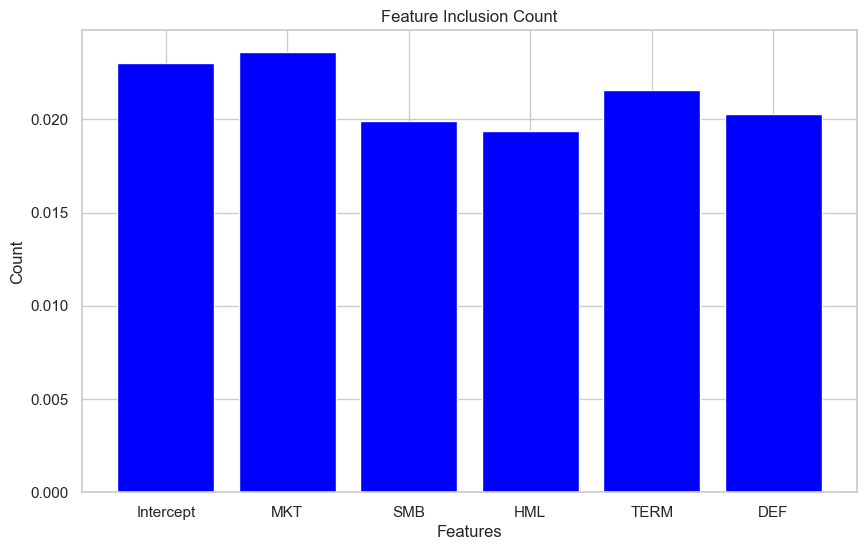

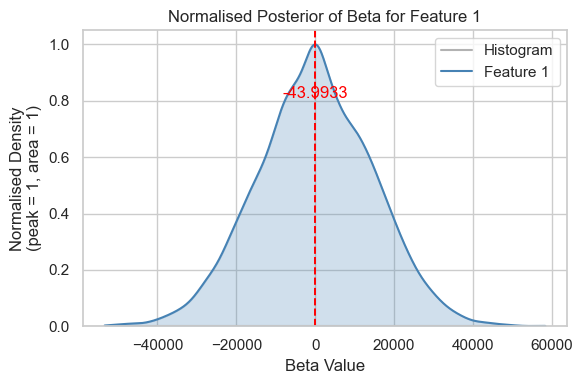

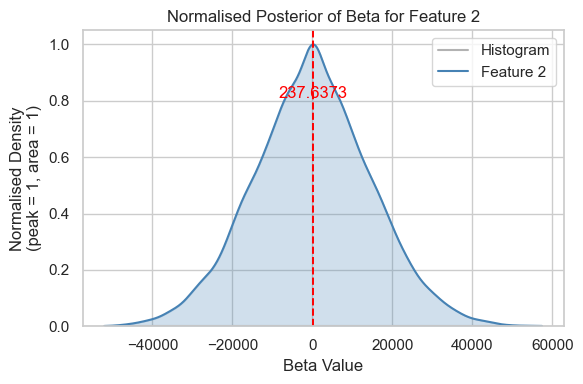

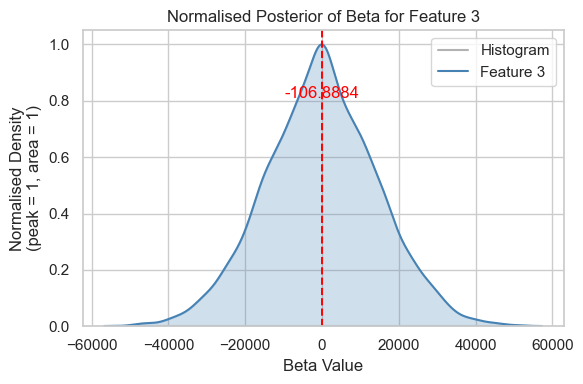

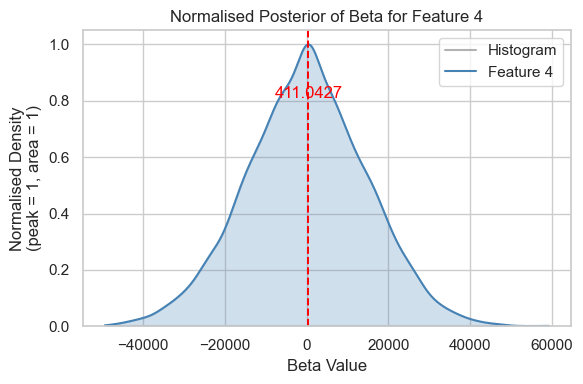

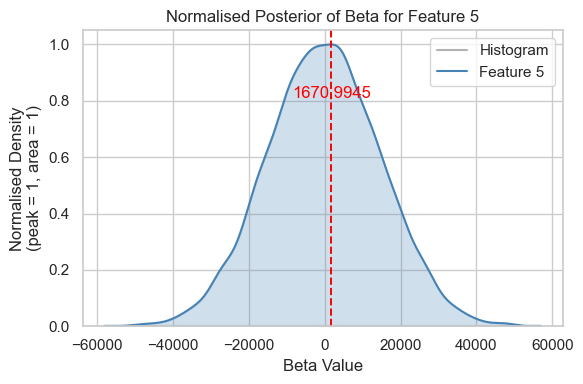

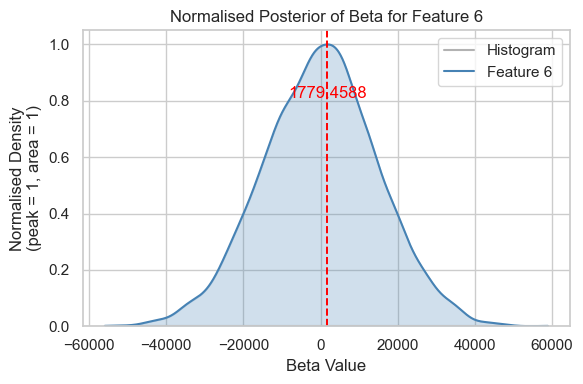

100%|██████████| 10000/10000 [00:17<00:00, 570.77it/s]


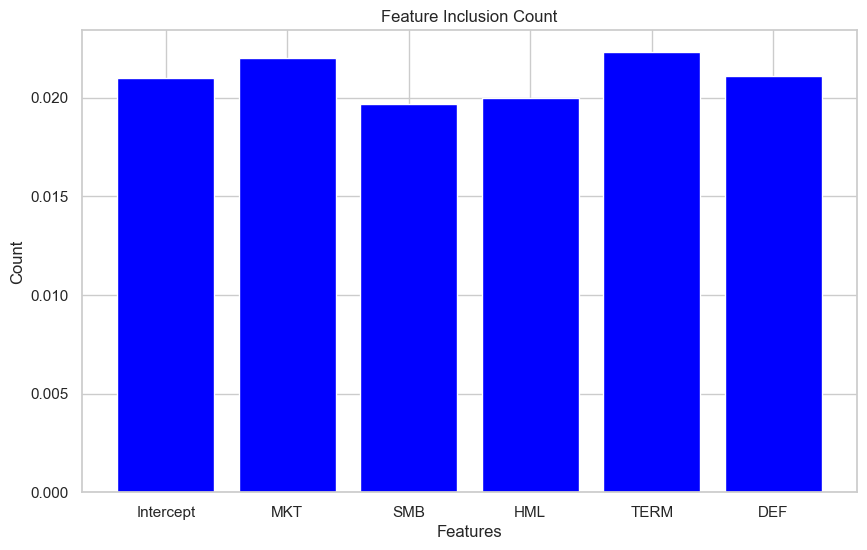

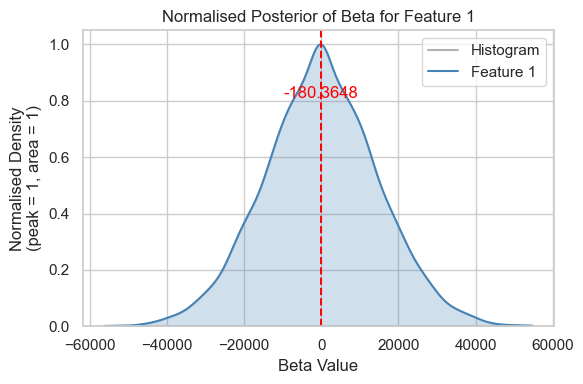

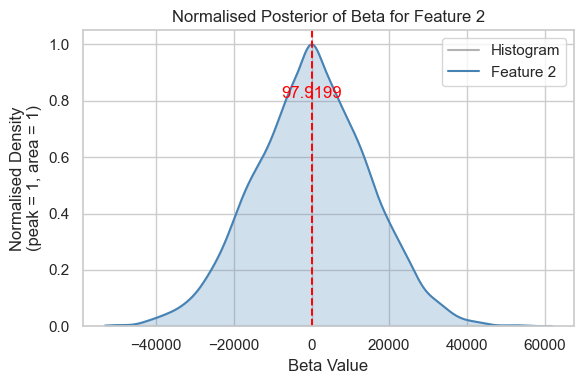

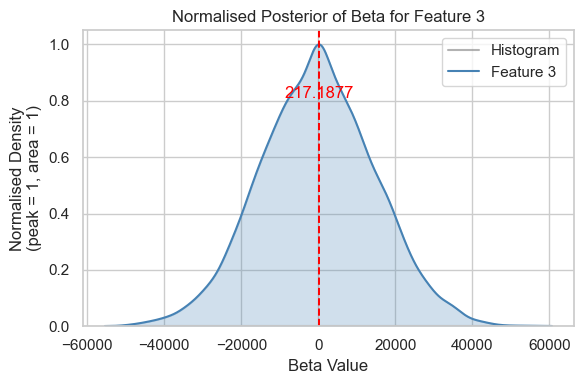

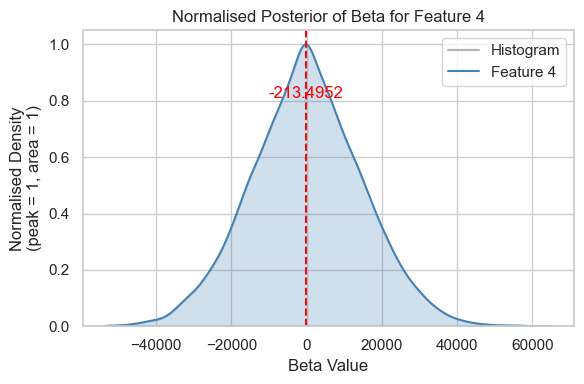

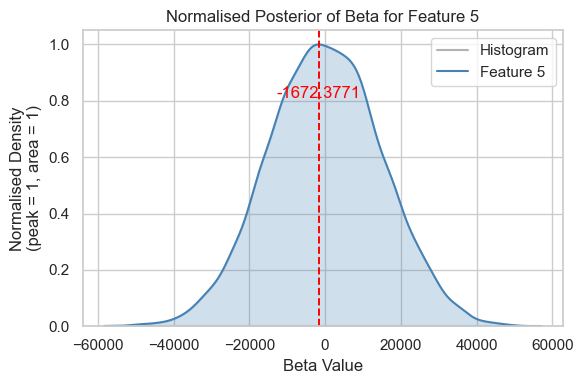

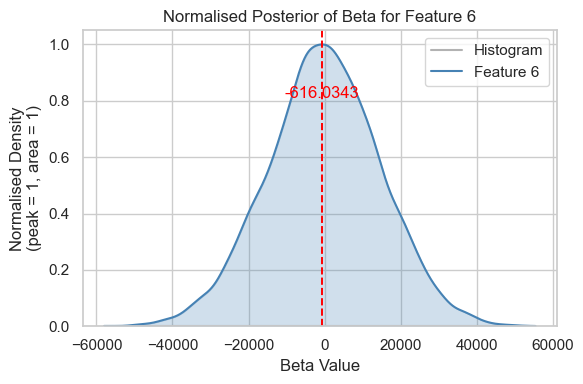

100%|██████████| 10000/10000 [00:16<00:00, 590.53it/s]


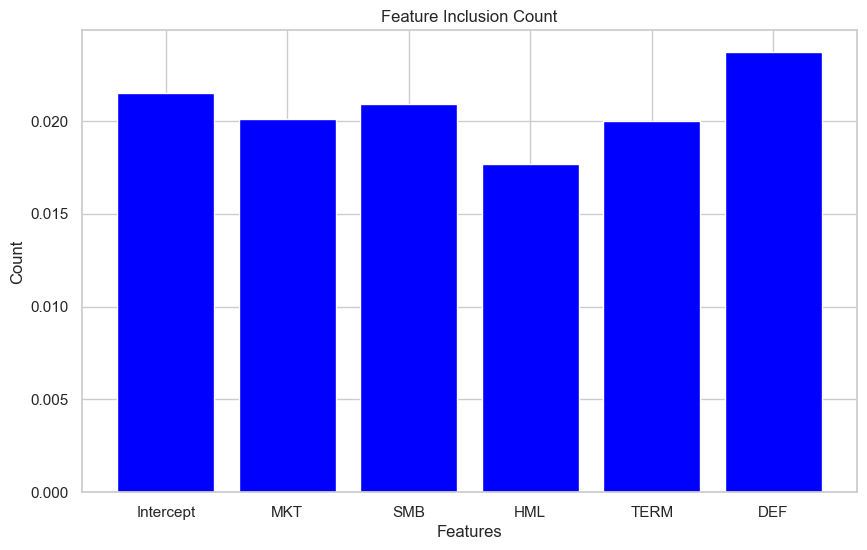

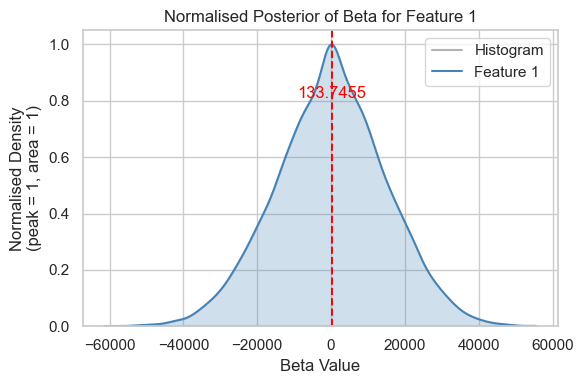

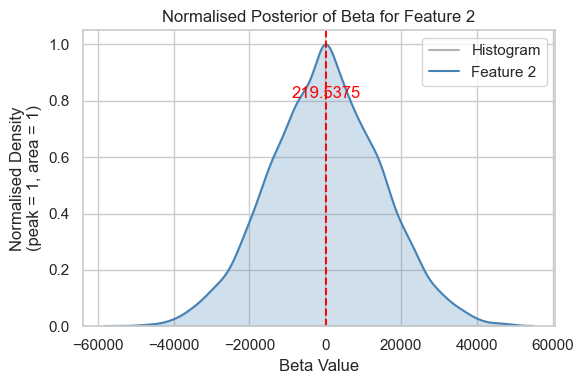

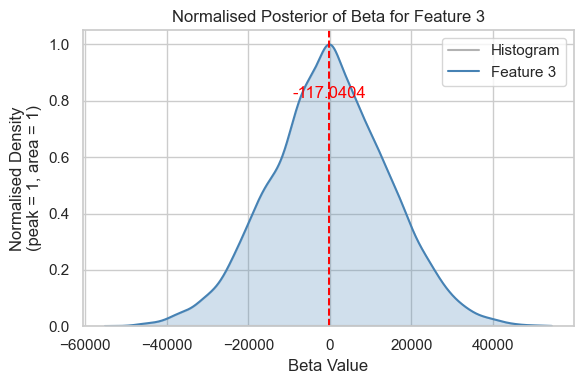

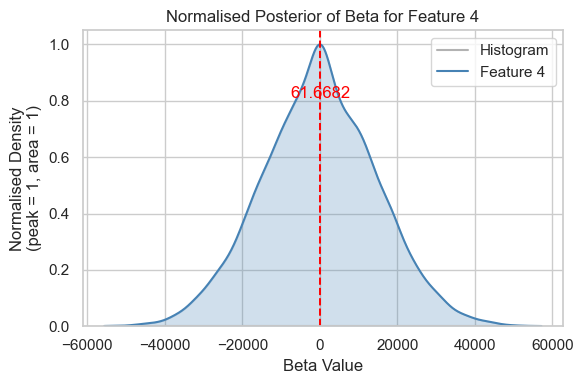

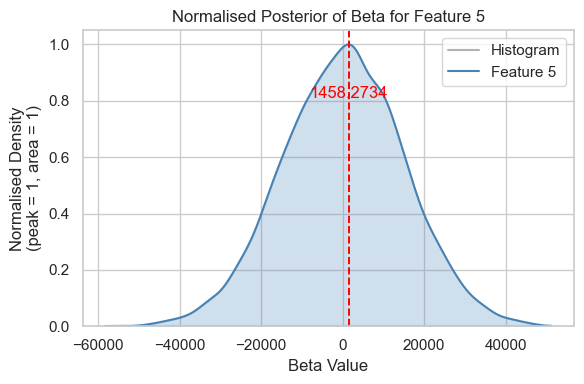

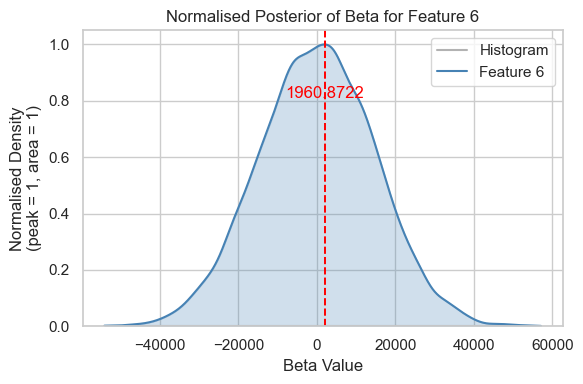

100%|██████████| 10000/10000 [00:16<00:00, 610.55it/s]


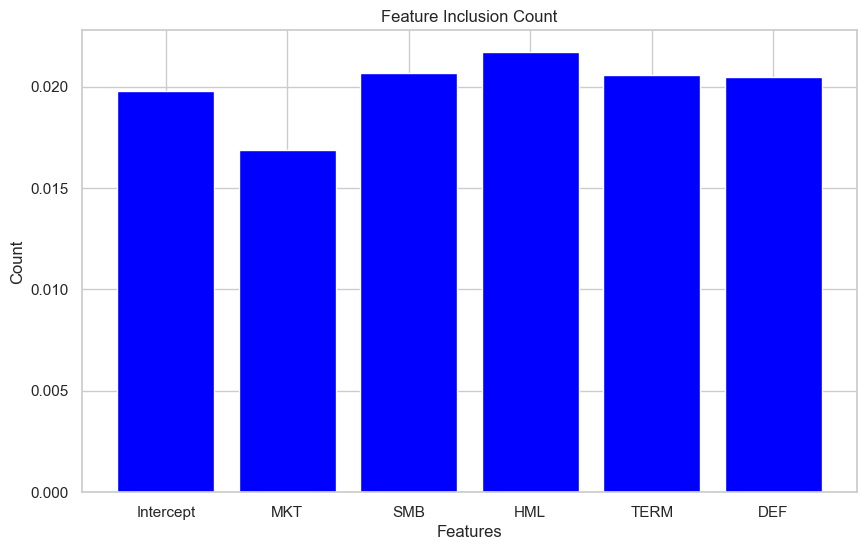

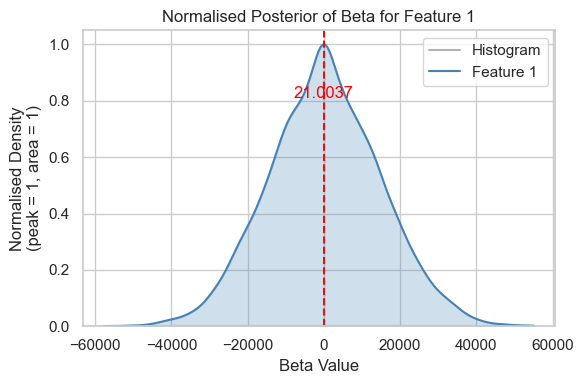

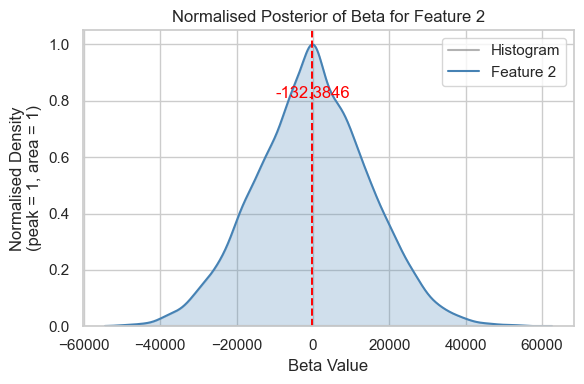

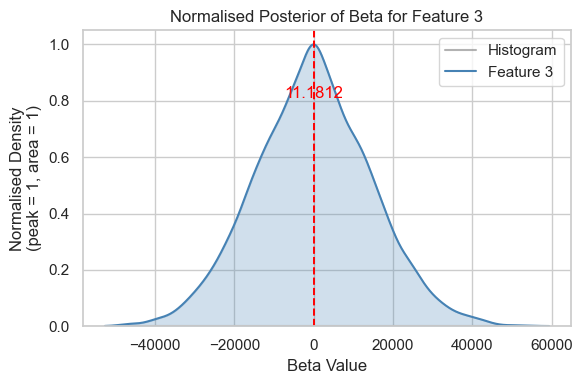

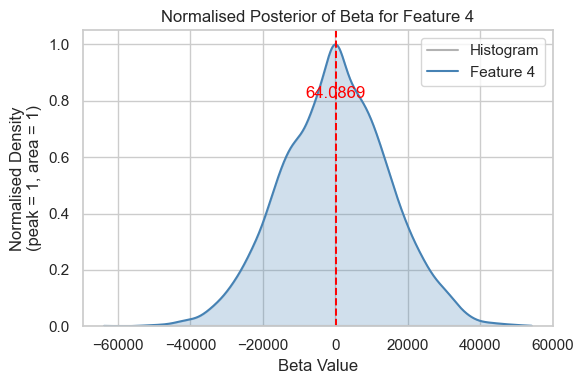

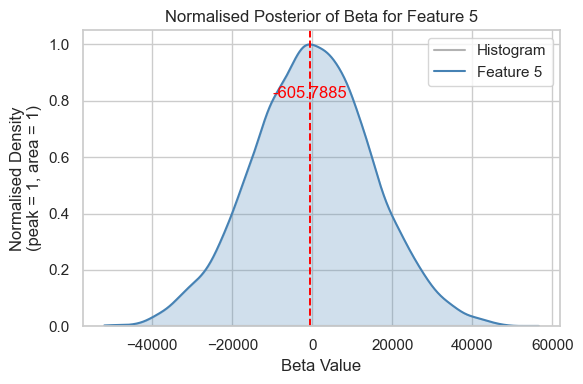

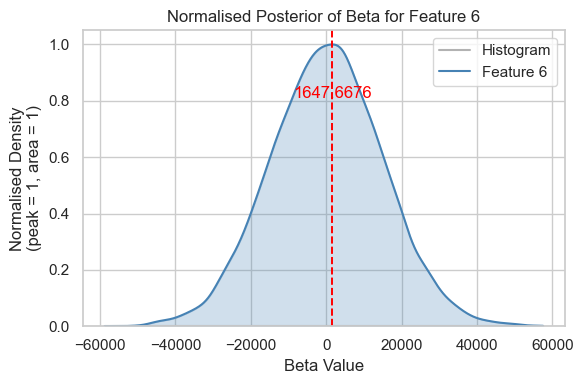

100%|██████████| 10000/10000 [00:16<00:00, 589.70it/s]


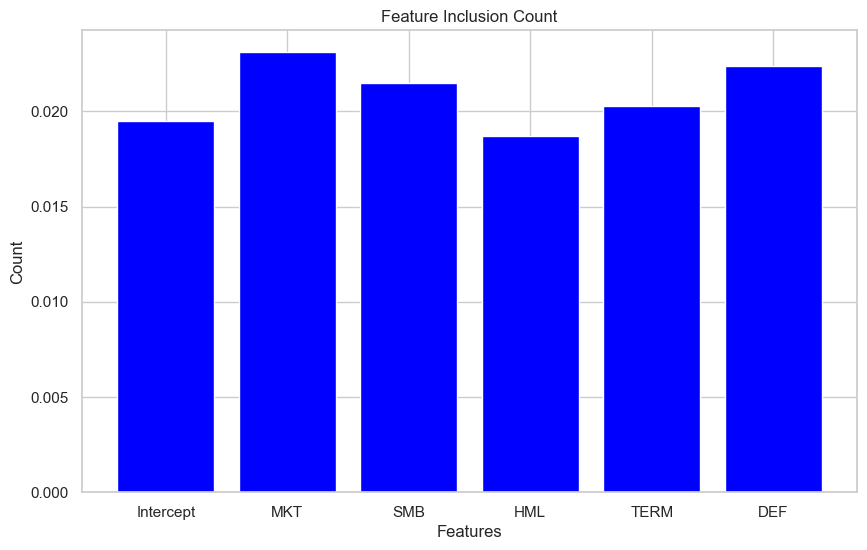

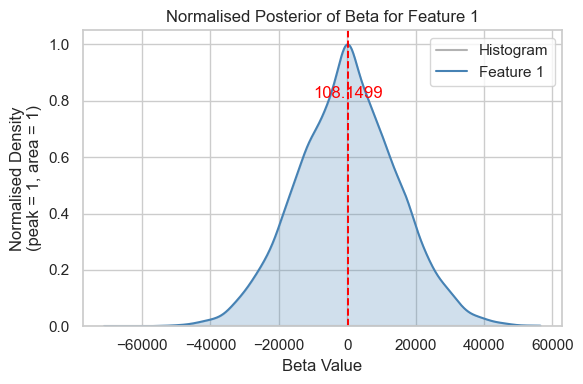

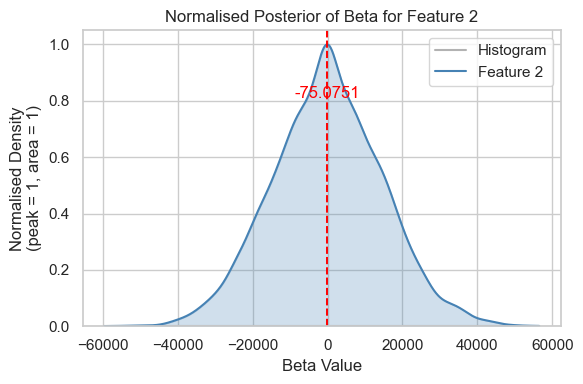

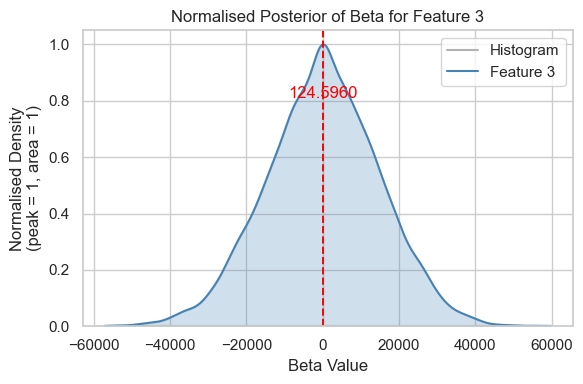

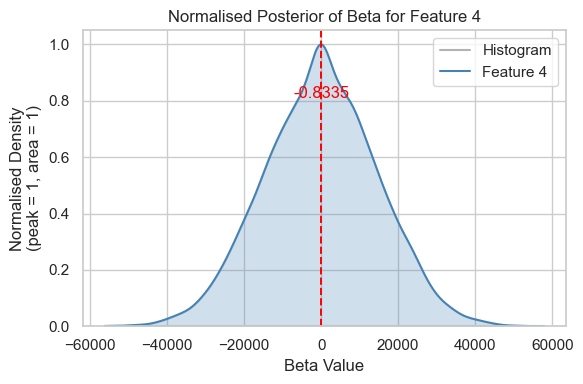

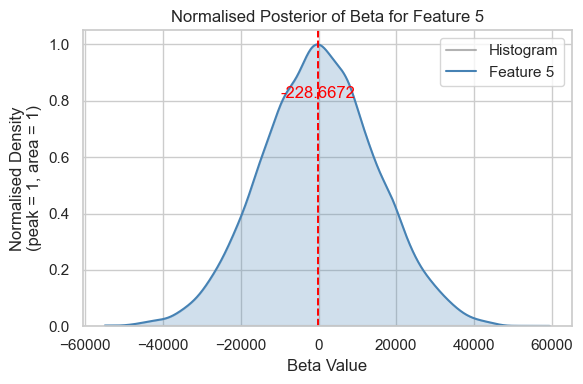

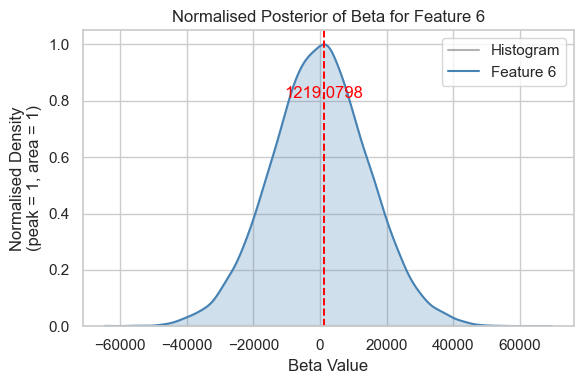

  7%|▋         | 729/10000 [00:01<00:15, 585.60it/s]


KeyboardInterrupt: 

In [197]:
for universe in universe_list:
    y = (np.array(port_df[universe]) - np.array(factors['RF'])).reshape(-1, 1)
    S = 10000
    samples = MCMC(y, S)
    plot_prob(samples)
    plot_beta_distributions(samples)